In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Preprocessing

In [2]:
path = '/kaggle/input/animals10/raw-img'
classes = os.listdir(path)

images = []
labels = []

for class_name in classes:
    class_path = os.path.join(path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        images.append(image_path)
        labels.append(class_name)

In [3]:
# Putting the data into dataframe
df = pd.DataFrame({'image_paths' : images, 'label' : labels})
df.head()

,image_paths,label
0,/kaggle/input/animals10/raw-img/cavallo/OIP-md...,cavallo
1,/kaggle/input/animals10/raw-img/cavallo/OIP-TP...,cavallo
2,/kaggle/input/animals10/raw-img/cavallo/OIP-jl...,cavallo
3,/kaggle/input/animals10/raw-img/cavallo/OIP-F4...,cavallo
4,/kaggle/input/animals10/raw-img/cavallo/OIP-UF...,cavallo


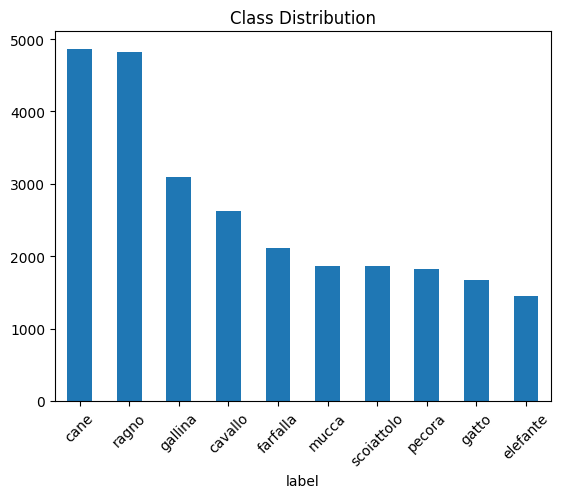

In [5]:
df['label'].value_counts().plot(kind = 'bar', title='Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Resizing and Normalization for images 

img_size = (224, 224)

def resize_normalize_images(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0

    return img   

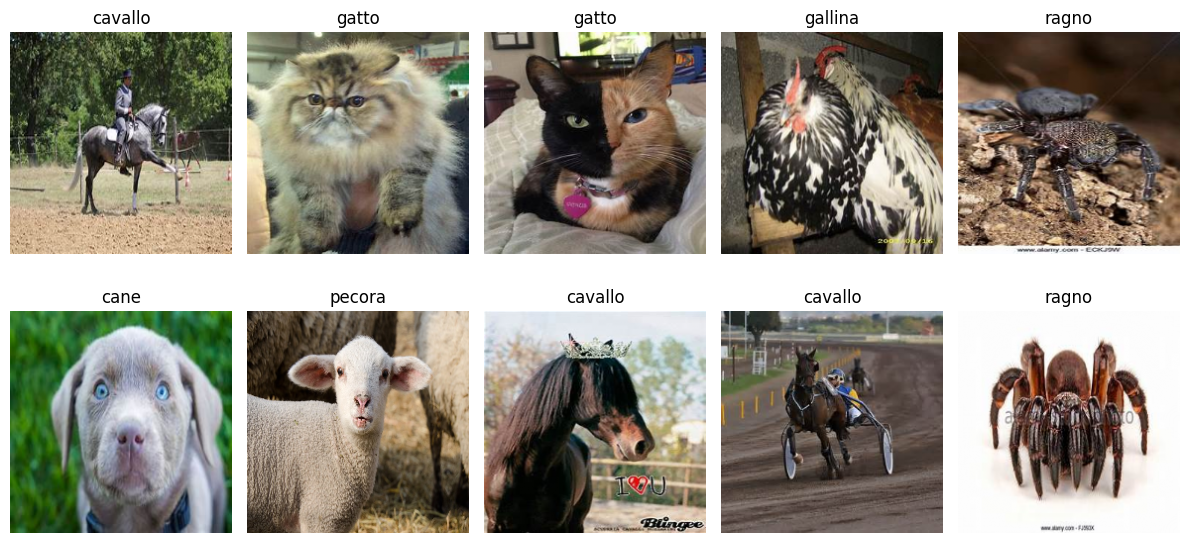

In [5]:
# Visualizing some images

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
sample_images = df.sample(10).reset_index()

for i, ax in enumerate(axes.flat):
    img = resize_normalize_images(sample_images.loc[i, 'image_paths'])
    ax.imshow(img)
    ax.set_title(sample_images.loc[i, 'label'])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Data Augumentation (Oversampling)

In [6]:
# Augmentation for minority classes

from tqdm import tqdm  # To monitor progress

# Initialize the augmentation generator
data_generator = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True
)

def augment_images(df, min_count=3000):
    balanced_df = df.copy()
    new_data = []  # Store new images in a list instead of adding to DataFrame directly
    os.makedirs("augmented", exist_ok=True)

    # Process each class
    for label, count in tqdm(df['label'].value_counts().items(), desc="Augmenting Classes"):
        if count < min_count:
            sample_df = df[df['label'] == label]
            num_to_generate = min_count - count  # Number of new images needed
            
            for _ in range(num_to_generate):
                # Randomly select an image
                img_path = random.choice(sample_df['image_paths'].values)
                
                # Preprocess image
                img = resize_normalize_images(img_path)  # Optimize this function if slow
                img = np.expand_dims(img, 0)  # Add batch dimension
                
                # Generate augmented image
                aug_img = data_generator.flow(img, batch_size=1)[0][0]

                new_path = f"augmented/{label}_{len(balanced_df)}.jpg"
                cv2.imwrite(new_path, (aug_img * 255).astype(np.uint8)) 
                
                new_data.append({"image_paths": new_path, "label": label})

    # Convert list to DataFrame
    new_df = pd.DataFrame(new_data)
    balanced_df = pd.concat([balanced_df, new_df], ignore_index=True)
    
    return balanced_df

df_balanced = augment_images(df)

Augmenting Classes: 10it [02:05, 12.57s/it]


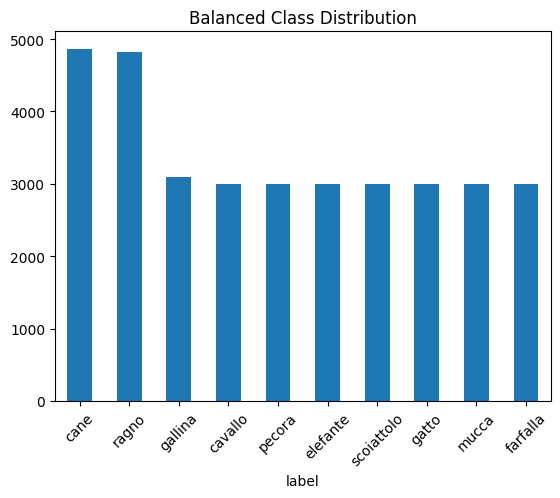

In [9]:
df_balanced['label'].value_counts().plot(kind='bar', title="Balanced Class Distribution")
plt.xticks(rotation=45)
plt.show()

# CNN Model

In [ ]:
# Define CNN architecture
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Prevent overfitting
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [12]:
# Splitting features and target
image_paths = df_balanced["image_paths"].values
labels = df_balanced["label"].astype('category').cat.codes.values  # Convert labels to numerical

In [14]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Load images into arrays
X_train = np.array([resize_normalize_images(path, img_size=(128, 128)) for path in X_train])
X_val = np.array([resize_normalize_images(path, img_size=(128, 128)) for path in X_val])

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

model = build_model(input_shape=(128, 128, 3), num_classes=len(set(labels)))

# Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

KeyboardInterrupt: 

In [ ]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
# Get predictions
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=set(df_balanced["label"]), yticklabels=set(df_balanced["label"]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Pretrained Models

## EfficientNetB6

In [17]:
# EfficientNetB6 archeticure
model = tf.keras.applications.EfficientNetB6(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None  # Avoid pooling here to keep the feature maps intact
)

# Custom layers
x = model.output
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)  # Apply MaxPooling2D to reduce dimensionality
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Pooling after MaxPooling2D (for dimension reduction)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout for regularization
x = tf.keras.layers.Dense(10, activation='softmax')(x)  # 10 classes (softmax for classification)

model = tf.keras.models.Model(inputs=model.input, outputs=x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',  # For integer labels
    metrics=['accuracy']
)


Found 27025 validated image filenames belonging to 10 classes.
Found 6757 validated image filenames belonging to 10 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


845/845 ━━━━━━━━━━━━━━━━━━━━ 988s 937ms/step - accuracy: 0.8586 - loss: 0.4988 - val_accuracy: 0.9148 - val_loss: 0.2810 - learning_rate: 0.0010
Epoch 2/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 644s 761ms/step - accuracy: 0.9316 - loss: 0.2386 - val_accuracy: 0.9303 - val_loss: 0.2834 - learning_rate: 0.0010
Epoch 3/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 644s 761ms/step - accuracy: 0.9429 - loss: 0.2060 - val_accuracy: 0.9331 - val_loss: 0.2277 - learning_rate: 0.0010
Epoch 4/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 644s 762ms/step - accuracy: 0.9569 - loss: 0.1491 - val_accuracy: 0.8761 - val_loss: 0.5862 - learning_rate: 0.0010
Epoch 5/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 645s 763ms/step - accuracy: 0.9647 - loss: 0.1268 - val_accuracy: 0.9435 - val_loss: 0.2081 - learning_rate: 0.0010
Epoch 6/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 644s 761ms/step - accuracy: 0.9669 - loss: 0.1137 - val_accuracy: 0.9402 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 7/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 644s 762ms/step - accuracy: 0.9660 

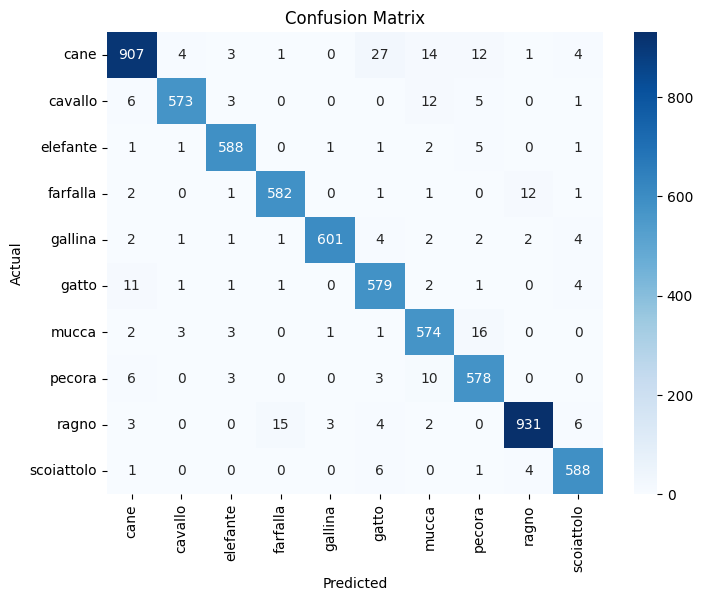

In [18]:
train_df, val_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced["label"], random_state=42)

# Define ImageDataGenerator for Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255  
)

val_datagen = ImageDataGenerator(rescale=1./255)  

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_paths",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_paths",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),  # Reduce LR if no improvement
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)  # Stop early if overfitting
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

val_preds = model.predict(val_generator)
val_preds = val_preds.argmax(axis=1)  
true_labels = val_generator.classes  

print(classification_report(true_labels, val_preds))

cm = confusion_matrix(true_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save('efficientnetb6_model.h5')

In [ ]:
class_labels = list(train_generator.class_indices.keys())  # Get class names from training generator

class_labels

## Prediction

In [ ]:
# Load and preprocess the image
def predict_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  
    img = img / 255.0  
    img = np.expand_dims(img, axis=0) 

    # Make a prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction) 

    # Get class name
    class_name = class_labels[predicted_class]
    confidence = prediction[0][predicted_class] 

    return class_name, confidence

sample_image = val_df.sample(1)
image_label = sample_image['label']
predicted_class, confidence = predict_image(sample_image['image_paths'].iloc[0], model)
print(f"Predicted class: {predicted_class} (Confidence: {confidence:.2f}) true label : {image_label}")

# Inception V3

In [7]:
from tensorflow.keras.applications import InceptionV3

img_height, img_width = 224, 224
batch_size = 32

base_model = InceptionV3(weights='imagenet', include_top = False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
model.compile(
    loss="sparse_categorical_crossentropy",       
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
    metrics=["accuracy"]  
)

In [10]:
train_df, val_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced["label"], random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255 
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_paths",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_paths",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

Found 27025 validated image filenames belonging to 10 classes.
Found 6757 validated image filenames belonging to 10 classes.


In [11]:
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),  # Reduce LR if no improvement
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)  # Stop early if overfitting
]

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


845/845 ━━━━━━━━━━━━━━━━━━━━ 170s 182ms/step - accuracy: 0.9290 - loss: 0.2516 - val_accuracy: 0.9526 - val_loss: 0.1700 - learning_rate: 0.0010
Epoch 2/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.9701 - loss: 0.0944 - val_accuracy: 0.9668 - val_loss: 0.1171 - learning_rate: 0.0010
Epoch 3/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.9776 - loss: 0.0688 - val_accuracy: 0.9679 - val_loss: 0.1121 - learning_rate: 0.0010
Epoch 4/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.9804 - loss: 0.0567 - val_accuracy: 0.9566 - val_loss: 0.1651 - learning_rate: 0.0010
Epoch 5/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.9838 - loss: 0.0476 - val_accuracy: 0.9685 - val_loss: 0.1203 - learning_rate: 0.0010
Epoch 6/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9870 - loss: 0.0383
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
845/845 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.9870 - loss: 0.0383

In [13]:
# Evaluating the Model
val_preds = model.predict(val_generator)
val_preds = val_preds.argmax(axis=1)  
true_labels = val_generator.classes 

212/212 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       973
           1       0.95      0.96      0.96       600
           2       0.99      0.97      0.98       600
           3       0.98      0.97      0.98       600
           4       0.95      0.98      0.96       620
           5       0.97      0.97      0.97       600
           6       0.96      0.93      0.95       600
           7       0.96      0.95      0.96       600
           8       0.98      0.99      0.98       964
           9       0.99      0.98      0.98       600

    accuracy                           0.97      6757
   macro avg       0.97      0.97      0.97      6757
weighted avg       0.97      0.97      0.97      6757



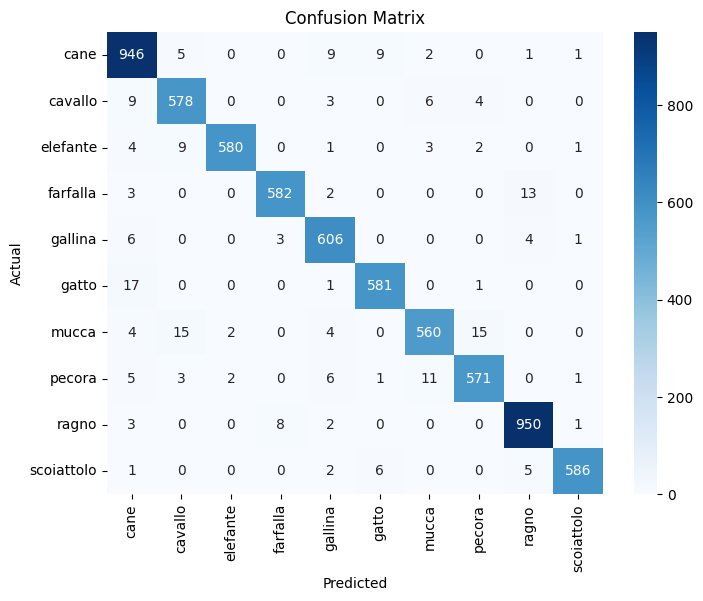

In [14]:
print(classification_report(true_labels, val_preds))

cm = confusion_matrix(true_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
model.save('InceptionV3_best_model.h5')